# Algorithm description
 - Callsign to words
    - all to capital letters
    - If everything is letters -> returns NATO spelling
    - Else: look for 2 or 3 first letters and associate with airline identifier, then spells the numbers + nato spelling 
- Hard matching:
    - Look if the callsign to word is in transcripted communication
    - Look for longest match (ex: LOT4 and LOT4NJ)
- Soft matching:
    - Look for callsigns that were in flight when the communication was made
    - Calcuates a matching score between call signs and transcript
    - Returns callsign with highest score (if greater than 3 matching words)
- Matching score:
    - Count the number of matching words between the transcript and the callsign by respecting the order (ex: AF756 -> 5 should be before 6)
    - Allow for miss classification of prefix (as airline idnetifier are harder to transcript than numbers)
    - Allow for additional words or missing between callsigns caracters (ex: AF756 -> air france seven five three six is a score of 5). Drwaback: introduce some false positives because it might takes into account numbers in clearances.

## Wargnings
- Soft matching sometimes messes up instruction with callsigns (as it allows for false words between consecutive character in callsign)
- Some callsigns in the communications seem to not appear in the adsb data
- What about callsigns that are not in the ICAO databases (might be charter or small aircraft) like PLF, JDI, FDB, GCK, SEH. Full letter callsigns are just transcribed with NATO alphabet
- Two communications might be within the same chunk (ex: chunks with LOT3MH) 
- Hard matching is confident but low rate of matchs. On the contrary, soft might give higher rate of matches but is sometimes wrong. How to verify when soft matching is right without listening to everything (generally I don't understand when the transcript is false). 

In [1]:
from traffic.core import Traffic
from utils.cs_matching import identify_callsigns_hard, identify_callsigns_soft, build_timestamp_range
from utils.liveatc_utils import extract_timestamp_from_path

adsb_path = "adsb/LSZH-lszh1_twr-Jul-23-2025-1000Z.parquet"
transcript_path = "transcripts/LSZH-lszh1_twr-Jul-23-2025-1000Z.txt"

adsb = Traffic.from_file(adsb_path)
timestamp_range = build_timestamp_range(adsb_path)

start_timestamp = extract_timestamp_from_path(transcript_path)

****
# Matchning
****

## ATCO2 matching

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
model = AutoModelForTokenClassification.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="first")

Device set to use cpu


In [29]:
import re

with open(transcript_path) as f:
    lines = [line.strip() for line in f if line.strip()]
    
for i, line in enumerate(lines):
    regex = re.match(r"\[(\d{2}:\d{2}:\d{2})\]\s*(.*)", line)
    timestamp = regex.group(1)
    sentence = regex.group(2)
    
    res = nlp(sentence)
    
    callsigns = [e for e in res if e['entity_group'] == 'callsign']
    if callsigns:
        top_callsign = max(callsigns, key=lambda e: e['score'])["word"]
    else:
        top_callsign = None
    
    print(f"[{i}]: {timestamp} {sentence} -> [{top_callsign}]")

[0]: 10:00:22 hotel golf yankee your art at ctr you may leave contact -> [hotel golf yankee]
[1]: 10:00:37 csa eight echo mike contact departure good bye -> [csa eight echo mike]
[2]: 10:00:39 departure that pikot one -> [None]
[3]: 10:00:56 hotel quebec india comming whiskey one three thousand -> [hotel quebec india]
[4]: 10:00:57 hotel quebec india -> [hotel quebec india]
[5]: 10:01:02 tower good day cimber three five five alfa foxtrot -> [foxtrot]
[6]: 10:01:09 two five five papa tower taxi to cross runway two eight and contact apron on one two one decimal seven five five good bye -> [two five five papa]
[7]: 10:01:15 hotel sierra juliett cross runway two eight one to one decimal seven five five good bye speed two five five papa -> [hotel sierra juliett]
[8]: 10:02:20 tower good day swiss one seven one tango juliett holding short rate -> [swiss one seven one tango juliett]
[9]: 10:02:24 one seven one tango hello cross runway two eight contact apron one two one decimal seven five fiv


## Hard matching


In [2]:
with open(transcript_path) as f:
    lines = [line.strip() for line in f if line.strip()]

matches_hard = identify_callsigns_hard(lines, timestamp_range.index.tolist())

i = 0
for match in matches_hard:
    print(f"{i}: {match['line']} -> {match['callsigns']}")
    i+=1

0: [10:00:22] hotel golf yankee your art at ctr you may leave contact -> []
1: [10:00:37] csa eight echo mike contact departure good bye -> []
2: [10:00:39] departure that pikot one -> []
3: [10:00:56] hotel quebec india comming whiskey one three thousand -> []
4: [10:00:57] hotel quebec india -> []
5: [10:01:02] tower good day cimber three five five alfa foxtrot -> []
6: [10:01:09] two five five papa tower taxi to cross runway two eight and contact apron on one two one decimal seven five five good bye -> []
7: [10:01:15] hotel sierra juliett cross runway two eight one to one decimal seven five five good bye speed two five five papa -> []
8: [10:02:20] tower good day swiss one seven one tango juliett holding short rate -> ['SWR171T']
9: [10:02:24] one seven one tango hello cross runway two eight contact apron one two one decimal seven five five -> []
10: [10:02:29] cleared to land on juliett one two one seven five five turkish one seven one tango -> []
11: [10:03:12] tower hello csa vi

In [3]:
total = 0
m = 0
cs = []
for match in matches_hard:
    total +=1
    if len(match['callsigns']) > 0:
        m += 1
        cs.append(match["callsigns"][0])
print(f"Proportion of lines matched with callsign: {m/total}")
print(f"Proportion of ADSB callsigns used for matching: {len(set(cs)) / len(adsb.data.callsign.unique())}")

Proportion of lines matched with callsign: 0.21468926553672316
Proportion of ADSB callsigns used for matching: 0.2191780821917808


- Identify the callsigns that are never matched and see what happens 
- Look at the consistencey between instruction and data
- Leverage the fact that there are pairs ATC/Pilot

## Soft matching

In [4]:
matches_soft = identify_callsigns_soft(lines, timestamp_range.index.tolist(), timestamp_range, session_start=start_timestamp)

i = 0
for match in matches_soft:
    print(f"{i}: {match['line']} -> {match['callsigns']}")
    i+=1

0: [10:00:22] hotel golf yankee your art at ctr you may leave contact -> [None]
1: [10:00:37] csa eight echo mike contact departure good bye -> ['SWR8EM']
2: [10:00:39] departure that pikot one -> [None]
3: [10:00:56] hotel quebec india comming whiskey one three thousand -> [None]
4: [10:00:57] hotel quebec india -> [None]
5: [10:01:02] tower good day cimber three five five alfa foxtrot -> [None]
6: [10:01:09] two five five papa tower taxi to cross runway two eight and contact apron on one two one decimal seven five five good bye -> ['SWR255P']
7: [10:01:15] hotel sierra juliett cross runway two eight one to one decimal seven five five good bye speed two five five papa -> ['SWR255P']
8: [10:02:20] tower good day swiss one seven one tango juliett holding short rate -> ['SWR171T']
9: [10:02:24] one seven one tango hello cross runway two eight contact apron one two one decimal seven five five -> ['SWR171T']
10: [10:02:29] cleared to land on juliett one two one seven five five turkish one 

In [5]:
total = 0
m = 0
for match in matches_soft:
    total +=1
    if match['callsigns'] != [None]:
        m += 1
print(f"Proportion of lines matched with callsign: {m/total}")

Proportion of lines matched with callsign: 0.6271186440677966


Handle incomplete callsigns when answering the ATC (ex: line 4.) -> Find a way to identfy the pairs ATC/Aircraft communications. Leverage that those communications are consecutive and information is repeated.  

## Comparison HARD VS SOFT

In [33]:
total = 0
count = 0
mismatchs = []
for i, (match_hard, match_soft) in enumerate(zip(matches_hard, matches_soft)):
    if match_hard["callsigns"]:
        total+=1
        if match_hard["callsigns"] == match_soft["callsigns"]:
            count +=1
        else:
            mismatchs.append((i, match_hard["callsigns"], match_soft["callsigns"]))
print(f"Proportion of matching between hard and soft algorithms: {count/total}")

Proportion of matching between hard and soft algorithms: 0.868421052631579


In [34]:
mismatchs

[(74, ['SWR569T'], ['SWR4AH']),
 (98, ['SWR569T'], [None]),
 (101, ['SWR569T'], ['SWR502V']),
 (102, ['SWR569T'], ['SWR4AH']),
 (175, ['SWR4TF'], [None])]

- Implement if hard matching, then select it. Else use soft matching.
- Implement proximity of word (ex lonk instead of lot) in soft matching
- Find a way to leverage what callsign has been detected in previous or future conversations.
- Try also to leverage that the callsign is either at the begining of at the end of the communication

****
# Matching Clearences to adsb data
****

In [35]:
adsb

,,count
icao24,callsign,
4b303c,HBSGY,2745
44065c,AUA555,2656
76ceed,SIA345,1986
4b15d8,EDW403Y,1863
4b19f3,SWR502V,1842
4b0dd0,HUE12P,1795
4b1b1b,HBKGX,1752
342107,IBE06AV,1738
a884b6,UAL53,1729


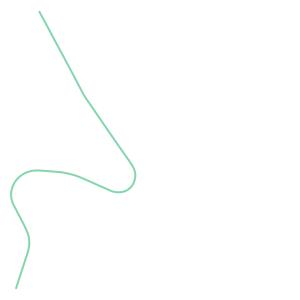

In [8]:
from datetime import datetime, timedelta
import pandas as pd

selected_cs = "AUA62V"
base_date = "2025-06-27"


associated_coms = []

for match in matches_soft:
    if match["callsigns"] == [selected_cs]:
        associated_coms.append(match["line"])

comm_times = [
    datetime.strptime(f"{base_date} {line[1:9]}", "%Y-%m-%d %H:%M:%S")
    for line in associated_coms
]

comm_df = pd.DataFrame({"timestamp": comm_times})

flight = adsb[selected_cs].filter()
flight = flight.after(pd.Timestamp(comm_times[0] - timedelta(seconds=10), tz="UTC"))
flight

In [9]:
associated_coms

['[12:34:11] lufthansa six two victor approach hello descend five thousand feet qnh one zero one three expect about four zero miles',
 '[12:35:45] lufthansa six two victor turn right heading zero nine zero',
 '[12:35:48] right heading zero nine zero austrian six two victor',
 '[12:36:55] austrian six two victor descend altitude three thousand feet',
 '[12:36:58] descend altitude three seven zero austrian six two victor',
 '[12:37:01] lufthansa six two victor and reduce speed two one zero',
 '[12:38:02] lufthansa six two victor report when ready for ils time',
 '[12:38:05] yeah in one minute call you austrian six three two',
 '[12:38:12] roger austrian six two victor when ready proceed to adelec point and cleared for ils approach runway three three',
 '[12:38:16] when ready direct el al three three austrian six two victor call you when ready',
 '[12:39:07] roger and cleared for ils approach runway three three cleared ils three three austrian six two victor',
 '[12:39:44] austrian six tw

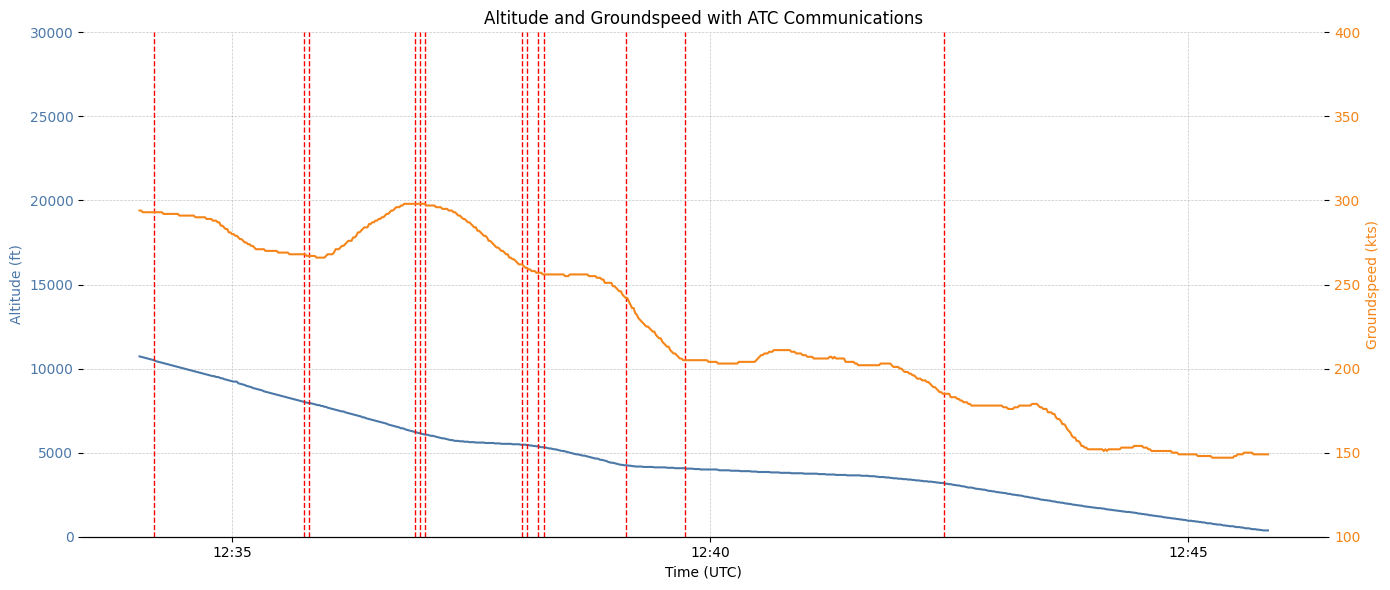

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Example flight DataFrame: assume `flight.data` is a pandas DataFrame with these columns
df = flight.data.copy()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Altitude plot
ax1.plot(df["timestamp"], df["altitude"], color="#4c78a8", label="Altitude (ft)")
ax1.set_ylabel("Altitude (ft)", color="#4c78a8")
ax1.tick_params(axis='y', labelcolor="#4c78a8")
ax1.set_ylim(0, 30000)

# Groundspeed plot on second y-axis
ax2 = ax1.twinx()
ax2.plot(df["timestamp"], df["groundspeed"], color="#f58518", label="Groundspeed (kts)")
ax2.set_ylabel("Groundspeed (kts)", color="#f58518")
ax2.tick_params(axis='y', labelcolor="#f58518")
ax2.set_ylim(100, 400)

# Add communication markers as vertical lines
for ts in comm_times:
    ax1.axvline(ts, color="red", linestyle="--", linewidth=1)

# Format x-axis with time
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel("Time (UTC)")
plt.title("Altitude and Groundspeed with ATC Communications")

ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
from ipyleaflet import Map, Marker

map = flight.map_leaflet()
for time in comm_times:
    marker = Marker(location=(flight.at(time).latitude, flight.at(time).longitude), draggable=False)
    map.add_layer(marker)

map

This timestamp is tz-naive. Things may not work as expected. If you construct your timestamps manually, consider passing a string, which defaults to UTC. If you construct your timestamps automatically, look at the tzinfo (resp. tz) argument of the datetime (resp. pd.Timestamp) constructor.
This timestamp is tz-naive. Things may not work as expected. If you construct your timestamps manually, consider passing a string, which defaults to UTC. If you construct your timestamps automatically, look at the tzinfo (resp. tz) argument of the datetime (resp. pd.Timestamp) constructor.
This timestamp is tz-naive. Things may not work as expected. If you construct your timestamps manually, consider passing a string, which defaults to UTC. If you construct your timestamps automatically, look at the tzinfo (resp. tz) argument of the datetime (resp. pd.Timestamp) constructor.
This timestamp is tz-naive. Things may not work as expected. If you construct your timestamps manually, consider passing a stri

Map(center=[51.940062592354515, 21.058045108822444], controls=(ZoomControl(options=['position', 'zoom_in_text'…